In [2]:
import os
import cv2
import skimage

import numpy as np
import sklearn
import pandas as pd  
import tensorflow as tf

from skimage.transform import resize
from keras.models import load_model
from mtcnn import MTCNN
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from embedding import l2_normalize,face_embedding

In [2]:
sklearn.__version__

'1.0.1'

In [3]:
image_train_path = '../data/faces/train/'
image_test_path = '../data/faces/test/'
# directory to gather the name of the celebrities and build the labels
image_dir_path = '../data/faces/train/'
names = [ name for name in os.listdir(image_dir_path) if os.path.isdir(os.path.join(image_train_path, name)) ]
print(names)

['BOUCHET, RAPHAELE', 'LOEW, JOACHIM', 'CONFINO, BASTIEN', 'CLIVAZ, FLORIAN', 'FISCHER, PATRICK (HOCKEYEUR)', 'DE WECK, GABRIEL', 'LAGRANGE, JEAN-JACQUES', 'OZIL, MESUT', 'ZISYADIS, ABRAHAM', 'BALE, GARETH']


In [10]:
# Choose the embeddings
# deep face 
#model_path = '../data/models/deepface/keras/deepface_fn_512.h5'
#model_path = '../data/models/deepface/keras/deepface_fn_128.h5'

# face net
#model_path = '../data/models/facenet/keras/facenet_ds_keras_128.h5'
model_path = '../data/models/facenet/keras/facenet_ds_keras_512.h5'

model_emb = load_model(model_path, compile = False , custom_objects={"tf": tf})


In [11]:
# face detection
min_face_size = 40
margin = 0 

# embeddings/croping size
image_size = 160

# fitler out multi faces in dictionary
max_nb_faces = 1

In [30]:
# MTCNN model
face_detector = MTCNN(min_face_size=min_face_size)

# repo of celebrity for training
image_dir_path = image_train_path

# faces
faces_emb = []
label = []
uuid_faces = []

for idx, name in enumerate(names):

    name_dir = image_dir_path + name
    image_filepaths = [os.path.join(name_dir, f)
                       for f in os.listdir(name_dir)]

    for iname, image in enumerate(image_filepaths):

        # for videos : image_np = frame_np
        image_np = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        face_crop, face_emb = face_embedding(image_np, face_detector,
                                             model_emb,
                                             max_nb_faces=max_nb_faces,
                                             margin=margin,
                                             image_size=image_size,
                                             flag_normalise=False,
                                             flag_plot=False)
        
        if face_emb.size > 0 : 
            faces_emb.append(face_emb)
            for k in range(np.shape(face_emb)[0]):
                label.append(name)

In [46]:
s = [ (np.shape(faces_emb[k]) , k) for k in range(len(faces_emb))]

In [47]:
faces_emb_train_np = np.concatenate(faces_emb, axis=0)
label_emb_train_np = np.array(label)

In [35]:
# instantiate the tsne 
# https://towardsdatascience.com/why-you-are-using-t-sne-wrong-502412aab0c0
tsne = TSNE(n_iter=1500, n_components=2, perplexity=10)

In [36]:
embs_tsne = tsne.fit_transform(faces_emb_train_np)

/Users/aro/.local/share/virtualenvs/benchmark-face-reco-f4UNL1EF/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aro/.local/share/virtualenvs/benchmark-face-reco-f4UNL1EF/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


# Visualisation of the embeddings space 

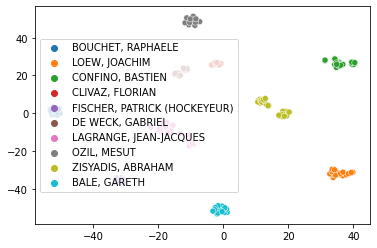

In [37]:
import mpld3
mpld3.enable_notebook()

x = embs_tsne[:, 0]
y = embs_tsne[:, 1]
faces_emb_train_np
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_emb_train_np)
plt.show()

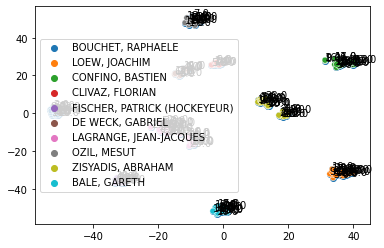

In [39]:
label_idx = np.zeros(len(label_emb_train_np))
for name in label_emb_train_np:
    name_image = label_emb_train_np == name
    label_idx[name_image == True,] = np.array(range(sum(name_image)))

fig, ax = plt.subplots()
ax.scatter(x, y)

p1 = sns.scatterplot(x=x, y=y, hue=label_emb_train_np)
for i, txt in enumerate(label_idx):
    p1.annotate(txt, (x[i], y[i]))
plt.show()

In [40]:
mpld3.disable_notebook()

# Unsupervised learning

#### K-NN

KNNclassifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                  metric='minkowski', metric_params=None, n_jobs=None)

In [44]:
# MTCNN model
face_detector = MTCNN(min_face_size=min_face_size)

# repo of celebrity for training
image_dir_path = image_test_path

# faces
faces_emb = []
label = []
uuid_faces = []

for idx, name in enumerate(names):

    name_dir = image_dir_path + name
    image_filepaths = [os.path.join(name_dir, f)
                       for f in os.listdir(name_dir)]

    for iname, image in enumerate(image_filepaths):

        # for videos : image_np = frame_np
        image_np = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        face_crop, face_emb = face_embedding(image_np, face_detector,
                                             model_emb,
                                             max_nb_faces=max_nb_faces,
                                             margin=margin,
                                             image_size=image_size,
                                             flag_normalise=False,
                                             flag_plot=False)
        
        if face_emb.size > 0 : 
            faces_emb.append(face_emb)
            for k in range(np.shape(face_emb)[0]):
                label.append(name)

In [50]:
faces_emb_test_np = np.concatenate(faces_emb, axis=0)
label_emb_test_np = np.array(label)

In [51]:
# instantiate the tsne 
tsne = TSNE(n_iter=15000, n_components=2, perplexity=10)
# compute the TSNE of the embeddings
embs_tsne = tsne.fit_transform(faces_emb_test_np)

/Users/aro/.local/share/virtualenvs/benchmark-face-reco-f4UNL1EF/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/aro/.local/share/virtualenvs/benchmark-face-reco-f4UNL1EF/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


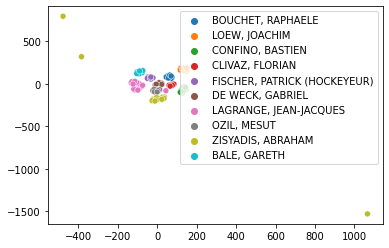

In [52]:
x = embs_tsne[:, 0]
y = embs_tsne[:, 1]
faces_emb_train_np
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, hue=label_emb_test_np)
plt.show()

# Train and test a classifier to recognise faces
> read the doc on KNN 
>> https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [53]:
# import KNN
from sklearn.neighbors import KNeighborsClassifier

In [54]:
# instanciate the classifier
KNNclassifier = KNeighborsClassifier(n_neighbors=10, weights='uniform', algorithm='brute', n_jobs=None)

In [55]:
# fit on training set
X_train = faces_emb_train_np
y_train = label_emb_train_np
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', n_neighbors=10)

In [56]:
# Evaluate on test set
X_test = faces_emb_test_np
y_predict_test_np = KNNclassifier.predict(X_test)

# Analyse the performance of the classifier 

In [57]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

a = accuracy_score (y_true = label_emb_test_np , y_pred = y_predict_test_np)

In [58]:
print(classification_report(y_true  = label_emb_test_np , y_pred = y_predict_test_np))

                              precision    recall  f1-score   support

                BALE, GARETH       1.00      1.00      1.00         8
           BOUCHET, RAPHAELE       1.00      1.00      1.00         8
             CLIVAZ, FLORIAN       1.00      1.00      1.00         5
            CONFINO, BASTIEN       1.00      1.00      1.00        10
            DE WECK, GABRIEL       1.00      1.00      1.00         6
FISCHER, PATRICK (HOCKEYEUR)       1.00      1.00      1.00         6
      LAGRANGE, JEAN-JACQUES       1.00      1.00      1.00        18
               LOEW, JOACHIM       1.00      1.00      1.00         9
                 OZIL, MESUT       1.00      1.00      1.00         8
           ZISYADIS, ABRAHAM       1.00      1.00      1.00        13

                    accuracy                           1.00        91
                   macro avg       1.00      1.00      1.00        91
                weighted avg       1.00      1.00      1.00        91



In [59]:
# for sake of readibility we generate short names with the 3 first letters of each names
short_names = [name[:3] for name in names ]

In [60]:
# function to analyse the grid search outputs
def print_grid_search(grid_search, param_grid):
    # read the best score and the best parameters
    best_param = grid_search.best_estimator_.get_params()
    best_score = grid_search.best_score_
    print('Best score :')
    print('===========')
    print('Mean cross-validated score of the best_estimator :')
    print(best_score)
    # read best parameters
    print()
    print('Best Parameters :')
    print('================')
    print('Parameter setting that gave the best results on the hold out data.')
    for param_name in param_grid[0].keys():
        print(param_name, " = ", best_param[param_name])

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = [{ 'n_neighbors' : [1,2,5,10,15,20]}]
estimator = KNeighborsClassifier( weights='uniform', algorithm='brute', n_jobs=None)

grid_search_knn = GridSearchCV(
    estimator = estimator , param_grid = param_grid , verbose=1, cv=5, n_jobs=-1,return_train_score=True)


In [62]:
%%time
grid_search_knn_res = grid_search_knn.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
CPU times: user 97.4 ms, sys: 200 ms, total: 297 ms
Wall time: 1.56 s


In [63]:
print_grid_search(grid_search_knn_res,param_grid )

Best score :
Mean cross-validated score of the best_estimator :
1.0

Best Parameters :
Parameter setting that gave the best results on the hold out data.
n_neighbors  =  1


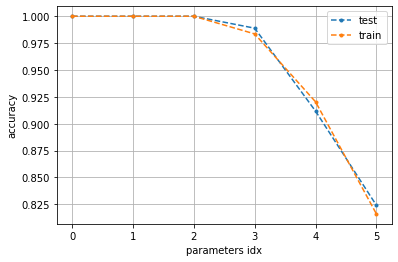

In [64]:
import matplotlib.pyplot as plt

mean_test_score = grid_search_knn_res.cv_results_['mean_test_score']
mean_train_score = grid_search_knn_res.cv_results_['mean_train_score']

plt.figure()
plt.plot(mean_test_score,label = 'test', marker = '.', linestyle='dashed')
plt.plot(mean_train_score, label = 'train',  marker = '.', linestyle='dashed')
plt.xlabel('parameters idx')
plt.ylabel('accuracy')
plt.legend()
plt.grid()


In [65]:
# then evaluate on the test set
# refit on the whole training set is performed by default
# the result is best_estimator_
X_test = faces_emb_test_np
y_test = label_emb_test_np
best_estimator = grid_search_knn_res.best_estimator_
y_test_esti = best_estimator.predict(X_test)
print(classification_report(y_test, y_test_esti, target_names=names))

                              precision    recall  f1-score   support

           BOUCHET, RAPHAELE       1.00      1.00      1.00         8
               LOEW, JOACHIM       1.00      1.00      1.00         8
            CONFINO, BASTIEN       1.00      1.00      1.00         5
             CLIVAZ, FLORIAN       1.00      1.00      1.00        10
FISCHER, PATRICK (HOCKEYEUR)       1.00      1.00      1.00         6
            DE WECK, GABRIEL       1.00      1.00      1.00         6
      LAGRANGE, JEAN-JACQUES       1.00      1.00      1.00        18
                 OZIL, MESUT       1.00      1.00      1.00         9
           ZISYADIS, ABRAHAM       1.00      1.00      1.00         8
                BALE, GARETH       1.00      1.00      1.00        13

                    accuracy                           1.00        91
                   macro avg       1.00      1.00      1.00        91
                weighted avg       1.00      1.00      1.00        91



In [66]:
X_test.shape

(91, 512)

# Confusion matrix 
> https://en.wikipedia.org/wiki/Confusion_matrix <br>
> with scikit learn 

> plot the confusion matrix: 
>> y_true = label_emb_test_np <br>
>> y_pred = y_predict_test_np  <br>
>> labels =short names generated precedingly <br> 

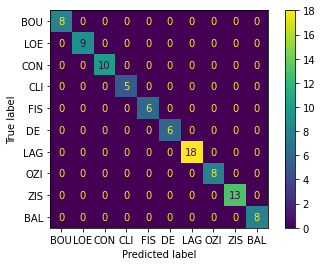

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=label_emb_test_np,
                      y_pred=y_predict_test_np, labels=names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=short_names)
disp.plot()
plt.show()